In [17]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
folder_path = 'mouseDataExpBCompl'


exclude_ids = ['9468', '9902',  # Error Outlier
               '2786', '6382', '6892',  # Bugs
               '5883',  # Incomplete Data
               '2878', '4420', '2523', '9025']  # Touchpad User

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
filtered_files = [
    file for file in csv_files
    if not any(ex_id in os.path.basename(file) for ex_id in exclude_ids)
]

# Einlesen
dataframes = [pd.read_csv(file) for file in filtered_files]
# filenames = [os.path.basename(file) for file in csv_files]


### Alle die mit 1 in df_for_trialexclusion markiert sind rausschmeißen

In [18]:
exclusion_df = pd.read_csv('df_for_trialexclusion.csv') 
# habe in trialexecution block zu round umbenannt
excluded = exclusion_df[exclusion_df['trial_excl'] == 1][['id', 'round', 'trial']]
dataframes_without_excluded = []

for df in dataframes:
    if all(col in df.columns for col in ['id', 'round', 'trial']):
        merged = df.merge(excluded, on=['id', 'round', 'trial'], how='left', indicator=True)
        df_cleaned = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
        dataframes_without_excluded.append(df_cleaned)
    else:
        dataframes_without_excluded.append(df) 

In [19]:
print(len(dataframes_without_excluded[0]))
print(len(dataframes[0]))

88112
96422


### leere dataframes rausschmeißen

In [20]:
dataframes_without_excluded = [
    df for df in dataframes_without_excluded
    if isinstance(df, pd.DataFrame) and not df.empty
]

In [21]:
len(dataframes_without_excluded)

50

### in blöcke einteilen und alle Zeilen mit Waiting for Target rauswerfen

In [22]:
block_pairs = [(1, 2), (3, 4), (5, 6), (7, 8)]
all_blocks = {f"{a}_{b}": [] for a, b in block_pairs}

for df in dataframes:
    df = df[df['phase'] != 'waitingForTarget']  # Phase-Filter
    for a, b in block_pairs:
        df_block = df[df['round'].isin([a, b])].reset_index(drop=True)
        all_blocks[f"{a}_{b}"].append(df_block)

### Nur timestamp, mouse_x, mouse_y, version und id behalten und die trials gruppieren -> 1 trial in einer Zeile

In [23]:
grouped_blocks = {
    '1_2': [],
    '3_4': [],
    '5_6': [],
    '7_8': []
}

for key in grouped_blocks.keys():
    for df in all_blocks[key]:
        df_grouped = df.groupby(['round', 'trial']).agg({
            'timestamp': list,
            'mouse_x': list,
            'mouse_y': list,
            'version': 'first',
            'id': 'first'
        }).reset_index()
        grouped_blocks[key].append(df_grouped)


In [24]:
grouped_df_1_2 = grouped_blocks["1_2"]
grouped_df_3_4 = grouped_blocks["3_4"]
grouped_df_5_6 = grouped_blocks["5_6"]
grouped_df_7_8 = grouped_blocks["7_8"]

### X und Y werte normalisieren, also auf 0.0 setzen -> für genormten startpunkt (is aber im endeffekt unnötig)

In [25]:
def normalize_positions(row):
    # Normalisieren (Startpunkt auf 0,0 setzen)
    x_positions = np.array(row["mouse_x"])
    y_positions = np.array(row["mouse_y"])
    
    x_start, y_start = x_positions[0], y_positions[0]
    x_norm = x_positions - x_start
    y_norm = y_positions - y_start

    row["mouse_x"] = x_norm
    row["mouse_y"] = y_norm

    return row


In [26]:
grouped_dfs = {
    '1_2': grouped_df_1_2,
    '3_4': grouped_df_3_4,
    '5_6': grouped_df_5_6,
    '7_8': grouped_df_7_8
}

processed_dfs = {}

for key, df_list in grouped_dfs.items():
    processed_dfs[key] = [df.apply(normalize_positions, axis=1) for df in df_list]


### Euklidische Distanz berechnen und in eine neue Spalte hinzufügen

In [27]:
def calculate_euclidean_distances(row):
    x = row['mouse_x']
    y = row['mouse_y']
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.sqrt(dx**2 + dy**2)
    return np.insert(dist, 0, 0.0)  # Schrittweiten, erste ist 0


In [28]:
def is_valid_array(val):
    import numpy as np
    if not isinstance(val, np.ndarray):
        return False
    try:
        return len(val) > 1
    except TypeError:
        return False

processed_dataframes_clean = {}

for key, df_list in processed_dfs.items():
    cleaned_list = []
    for df in df_list:
        df_clean = df[df.apply(
            lambda row: is_valid_array(row['mouse_x']) and is_valid_array(row['mouse_y']),
            axis=1
        )]
        cleaned_list.append(df_clean)
    processed_dataframes_clean[key] = cleaned_list

In [29]:
processed_dataframes_clean["1_2"]

[     round  trial                                          timestamp  \
 0        1      1  [14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...   
 1        1      2  [14:14:18.273, 14:14:18.289, 14:14:18.307, 14:...   
 2        1      3  [14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...   
 3        1      4  [14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...   
 4        1      5  [14:14:30.040, 14:14:30.056, 14:14:30.073, 14:...   
 ..     ...    ...                                                ...   
 115      2     56  [14:21:05.375, 14:21:05.389, 14:21:05.410, 14:...   
 116      2     57  [14:21:08.561, 14:21:08.573, 14:21:08.590, 14:...   
 117      2     58  [14:21:11.806, 14:21:11.823, 14:21:11.841, 14:...   
 118      2     59  [14:21:14.840, 14:21:14.856, 14:21:14.874, 14:...   
 119      2     60  [14:21:17.540, 14:21:17.558, 14:21:17.572, 14:...   
 
                                                mouse_x  \
 0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
 1  

In [30]:
for key, df_list in processed_dataframes_clean.items():
    for i, df in enumerate(df_list):
        df = df.copy()
        df['euk_dist'] = df.apply(calculate_euclidean_distances, axis=1)
        df_list[i] = df


### Geschwindigkeit in den zeitfenstern berechnen

In [ ]:
def calculate_speed(row, window_ms=20):
    timestamps = row['timestamp']
    euk_dist = row['euk_dist']

    # timestamps in datetime-Objekte, aber nur zeit
    times = [datetime.strptime(ts, '%H:%M:%S.%f') for ts in timestamps]

    # zeitdifferenzen zum startzeitpunkt berechnen also z.b: 5, 10, 15...
    start_time = times[0]
    elapsed_ms = np.array([(t - start_time).total_seconds() * 1000 for t in times])

    # zeitfenster einteilen nach window_ms also 1. zeitfenster 0-20ms ...
    window_ids = (elapsed_ms // window_ms).astype(int)
    # print(window_ids)
    if len(window_ids) > 1000:
        print(window_ids)
    # für jedes fenster summe von euk dist berechnen berechnen
    if len(euk_dist) == len(timestamps):
        dist_to_sum = np.array(euk_dist)
    elif len(euk_dist) == len(timestamps) - 1:
        dist_to_sum = np.array(euk_dist)
        window_ids = window_ids[:-1] 
    else:
        raise ValueError("len timestamps und euk_dist passen nicht zusammen")

    # Summe pro fenster
    import collections
    dist_per_window = collections.defaultdict(float)
    for w_id, dist in zip(window_ids, dist_to_sum):
        dist_per_window[w_id] += dist

    # geschwindigkeit pro fenster = Distanz / Zeit (Zeit = window_ms ms = window_ms / 1000 s)
    speed_per_window = {w: dist / (window_ms / 1000) for w, dist in dist_per_window.items()}

    max_window = max(window_ids)
    speeds = [speed_per_window.get(i, 0) for i in range(max_window + 1)]

    return speeds


In [36]:
for key, df_list in processed_dataframes_clean.items():
    for i, df in enumerate(df_list):
        df = df.copy()  # sicherheitshalber
        df['speed'] = df.apply(calculate_speed, axis=1)
        df_list[i] = df


### in die Conditions aufteilen: LLD und RLD

In [37]:
df_lld = {}
df_rld = {}

for key, df_list in processed_dataframes_clean.items():
    df_lld[key] = []
    df_rld[key] = []
    
    for df in df_list:
        version = df.iloc[0]['version']
        if version == 'lld':
            df_lld[key].append(df)
        elif version == 'rld':
            df_rld[key].append(df)


### TargetPos hinzufügen um dann unterscheiden zu können

In [38]:
def get_target_pos(row):
    last_x = row['mouse_x'][-1]
    return 'r' if last_x > 0 else 'l'

df['targetPos'] = df.apply(get_target_pos, axis=1)

In [39]:
for key, df_list in df_lld.items():
    print(key)
    for i, df in enumerate(df_list):
        target_pos_series = df.apply(get_target_pos, axis=1)
        df_lld[key][i] = df.copy() 
        df_lld[key][i]['targetPos'] = target_pos_series

1_2
3_4
5_6
7_8


In [40]:
for key, df_list in df_rld.items():
    print(key)
    for i, df in enumerate(df_list):
        target_pos_series = df.apply(get_target_pos, axis=1)
        df_rld[key][i] = df.copy() 
        df_rld[key][i]['targetPos'] = target_pos_series

1_2
3_4
5_6
7_8


In [44]:
# l und r in left condition aufteilen

df_lld_delay = {}
df_lld_no_delay = {}

for key, df_list in df_lld.items():
    df_lld_delay[key] = []
    df_lld_no_delay[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_lld_delay[key].append(df_left)
        df_lld_no_delay[key].append(df_right)


In [45]:
# l und r in right condition aufteilen

df_rld_no_delay = {}
df_rld_delay = {}

for key, df_list in df_rld.items():
    df_rld_no_delay[key] = []
    df_rld_delay[key] = []
    
    for df in df_list:
        df_left = df[df['targetPos'] == 'l'].reset_index(drop=True)
        df_right = df[df['targetPos'] == 'r'].reset_index(drop=True)
        
        df_rld_no_delay[key].append(df_left)
        df_rld_delay[key].append(df_right)


In [49]:
df_rld_no_delay["1_2"][0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed,targetPos
0,1,1,"[22:14:50.307, 22:14:50.324, 22:14:50.341, 22:...","[0.0, 0.03499999999999999, 0.081, 0.0959999999...","[0.0, -0.013000000000000012, -0.02900000000000...",rld,1611,"[0.0, 0.037336309405188936, 0.0487031826475437...","[1.8668154702594468, 2.435159132377185, 1.0965...",l
1,1,2,"[22:14:53.083, 22:14:53.099, 22:14:53.114, 22:...","[0.0, 0.007000000000000006, 0.0100000000000000...","[0.0, -0.0020000000000000018, -0.0020000000000...",rld,1611,"[0.0, 0.007280109889280525, 0.0030000000000000...","[0.36400549446402625, 0.15000000000000013, 0.0...",l
2,1,5,"[22:15:01.539, 22:15:01.555, 22:15:01.572, 22:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,1611,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0....",l
3,1,6,"[22:15:03.605, 22:15:03.622, 22:15:03.647, 22:...","[0.0, -0.07600000000000051, -0.102000000000000...","[0.0, 0.017000000000000015, 0.0620000000000000...",rld,1611,"[0.0, 0.07787810988975065, 0.05197114584074503...","[3.8939054944875324, 0, 3.404783066867106, 2.3...",l
4,1,7,"[22:15:06.538, 22:15:06.565, 22:15:06.571, 22:...","[0.0, 0.016999999999999904, 0.0219999999999997...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,1611,"[0.0, 0.016999999999999904, 0.0049999999999998...","[0.0, 1.0999999999999899, 0.10000000000000009,...",l
...,...,...,...,...,...,...,...,...,...,...
57,2,54,"[22:19:58.304, 22:19:58.321, 22:19:58.337, 22:...","[0.0, 0.2270000000000001, 0.7530000000000001, ...","[0.0, 0.045999999999999985, 0.2080000000000000...",rld,1611,"[0.0, 0.231613902864228, 0.5503816857418132, 0...","[11.5806951432114, 27.51908428709066, 21.44906...",l
58,2,55,"[22:20:00.304, 22:20:00.321, 22:20:00.337, 22:...","[0.0, 0.015999999999999792, 0.0219999999999997...","[0.0, 0.03399999999999999, 0.046, 0.061, 0.077...",rld,1611,"[0.0, 0.037576588456111774, 0.0134164078649987...","[1.8788294228055886, 0.6708203932499375, 0.751...",l
59,2,56,"[22:20:02.434, 22:20:02.451, 22:20:02.468, 22:...","[0.0, 0.038000000000000034, 0.0849999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",rld,1611,"[0.0, 0.038000000000000034, 0.0469999999999999...","[1.9000000000000017, 2.3499999999999965, 1.349...",l
60,2,59,"[22:20:09.653, 22:20:09.670, 22:20:09.687, 22:...","[0.0, 0.12899999999999998, 0.23999999999999996...","[0.0, -0.049999999999999996, -0.101, -0.163, -...",rld,1611,"[0.0, 0.13835100288758298, 0.12215563842901399...","[6.917550144379149, 6.107781921450699, 6.05392...",l


### Die Gruppen für jeden Block zusammenführen -> also delay und no delay

In [67]:
def combine_delay_groups_paired(group_key):
    list_lld = df_lld_delay[group_key]
    list_rld = df_rld_delay[group_key]
    return list_lld + list_rld


def combine_no_delay_groups_paired(group_key):
    list_lld = df_lld_no_delay[group_key]
    list_rld = df_rld_no_delay[group_key]
    return list_lld + list_rld



In [68]:
delay_1_2 = combine_delay_groups_paired("1_2")
delay_3_4 = combine_delay_groups_paired("3_4")
delay_5_6 = combine_delay_groups_paired("5_6")
delay_7_8 = combine_delay_groups_paired("7_8")

In [ ]:
no_delay_1_2 = combine_no_delay_groups_paired("1_2")
no_delay_3_4 = combine_no_delay_groups_paired("3_4")
no_delay_5_6 = combine_no_delay_groups_paired("5_6")
no_delay_7_8 = combine_no_delay_groups_paired("7_8")

In [73]:
delay_1_2[0]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed,targetPos
0,1,1,"[14:14:14.373, 14:14:14.390, 14:14:14.409, 14:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0....",l
1,1,3,"[14:14:21.623, 14:14:21.639, 14:14:21.657, 14:...","[0.0, 0.0, -0.010999999999999982, -0.014999999...","[0.0, 0.0, -0.012, -0.015, -0.017, -0.017, -0....",lld,1085,"[0.0, 0.0, 0.016278820596099693, 0.00500000000...","[0.0, 0.8139410298049846, 0.2500000000000001, ...",l
2,1,4,"[14:14:25.489, 14:14:25.507, 14:14:25.523, 14:...","[0.0, 0.023, 0.031, 0.033, 0.05699999999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.011999999999...",lld,1085,"[0.0, 0.023, 0.008, 0.0020000000000000018, 0.0...","[1.15, 0.4, 0.10000000000000009, 1.19999999999...",l
3,1,7,"[14:14:36.256, 14:14:36.274, 14:14:36.290, 14:...","[0.0, -0.055999999999999994, -0.12, -0.2089999...","[0.0, -0.025, -0.056, -0.089, -0.0999999999999...",lld,1085,"[0.0, 0.06132699242584785, 0.0711125867902441,...","[3.0663496212923924, 3.5556293395122047, 4.746...",l
4,1,10,"[14:14:46.057, 14:14:46.073, 14:14:46.089, 14:...","[0.0, -0.136, -0.33899999999999997, -0.531, -0...","[0.0, -0.048999999999999995, -0.122, -0.18, -0...",lld,1085,"[0.0, 0.14455794685869056, 0.21572667892497668...","[7.2278973429345275, 10.786333946248835, 10.02...",l
5,1,16,"[14:15:04.606, 14:15:04.623, 14:15:04.641, 14:...","[0.0, -0.01200000000000001, -0.015000000000000...","[0.0, -0.0030000000000000027, -0.0040000000000...",lld,1085,"[0.0, 0.012369316876852991, 0.0031622776601683...","[0.6184658438426496, 0.1581138830084191, 0.100...",l
6,1,17,"[14:15:08.824, 14:15:08.840, 14:15:08.856, 14:...","[0.0, -0.006000000000000005, -0.00800000000000...","[0.0, 0.008000000000000007, 0.0110000000000000...",lld,1085,"[0.0, 0.010000000000000009, 0.0036055512754639...","[0.5000000000000004, 0.18027756377319962, 0.07...",l
7,1,20,"[14:15:18.156, 14:15:18.177, 14:15:18.192, 14:...","[0.0, 0.0010000000000000009, 0.001000000000000...","[0.0, -0.01100000000000001, -0.037000000000000...",lld,1085,"[0.0, 0.01104536101718727, 0.02599999999999999...","[0.0, 1.8522680508593632, 1.188486432400471, 1...",l
8,1,22,"[14:15:24.257, 14:15:24.275, 14:15:24.291, 14:...","[0.0, 0.023999999999999994, 0.032, 0.035, 0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1085,"[0.0, 0.023999999999999994, 0.0080000000000000...","[1.1999999999999997, 0.40000000000000036, 0.15...",l
9,1,24,"[14:15:31.025, 14:15:31.041, 14:15:31.056, 14:...","[0.0, -0.18799999999999994, -0.353, -0.4539999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.023000000000000007...",lld,1085,"[0.0, 0.18799999999999994, 0.16500000000000004...","[9.399999999999997, 8.250000000000002, 5.04999...",l


### durchschnittliche geschwindigkeit pro teilnehmer über zeit berechnen 

In [75]:
target_time_ms = np.arange(0, 4000 + 1, 20)  # 0 bis 4000ms in 20ms Schritten

def compute_avg_speed_per_group(df_list, target_time_ms):
    avg_speeds = []
    for df in df_list:
        aligned_speeds = []
        for speed in df['speed']:
            aligned_speed = np.zeros(len(target_time_ms))

        if len(speed) > len(target_time_ms):
            speed = speed[:len(target_time_ms)]

        n_points = len(speed)

        # ab 1 dann mit speed werten auffüllen, da erster wert ja immer 0 ist
        if n_points > 1:
            aligned_speed[1:n_points] = speed[1:n_points]

        aligned_speeds.append(aligned_speed)
        if aligned_speeds:
            speed_matrix = np.vstack(aligned_speeds)
            mean_speed = np.mean(speed_matrix, axis=0)
            avg_speeds.append(mean_speed)
    return avg_speeds

# Deine 8 Gruppen DataFrames, die du vorher erstellt hast
groups_dict = {
    "delay_1_2": delay_1_2,
    "delay_3_4": delay_3_4,
    "delay_5_6": delay_5_6,
    "delay_7_8": delay_7_8,
    "no_delay_1_2": no_delay_1_2,
    "no_delay_3_4": no_delay_3_4,
    "no_delay_5_6": no_delay_5_6,
    "no_delay_7_8": no_delay_7_8,
}

avg_speed_all_groups = {}

for group_name, df_list in groups_dict.items():
    avg_speed_all_groups[group_name] = compute_avg_speed_per_group(df_list, target_time_ms)

# Jetzt hast du in avg_speed_all_groups für jede Gruppe eine Liste von mittleren Geschwindigkeitskurven


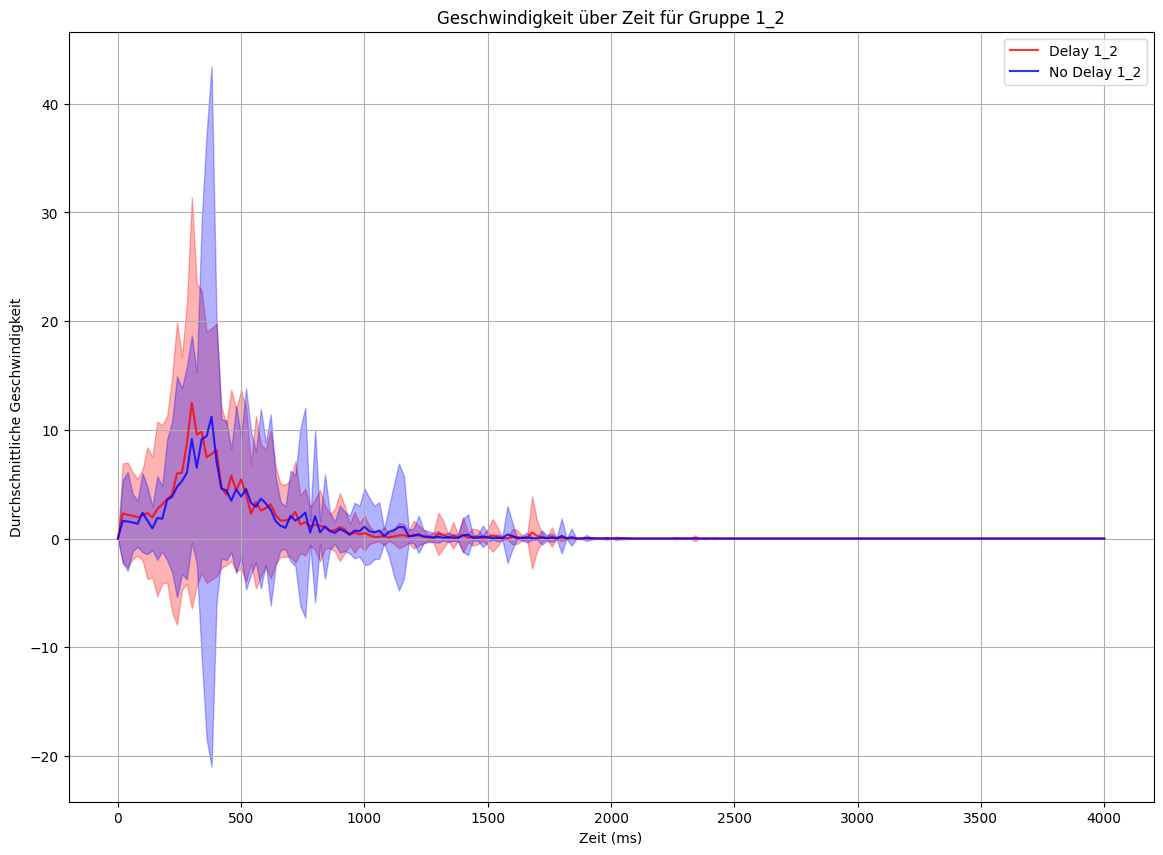

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Zeitachse: 0 bis 4000 ms in 20 ms Schritten
target_time_ms = np.arange(0, 4000 + 1, 20)  # 201 Punkte

# in 2d array für mittelwert
delay_speeds = np.vstack(avg_speed_all_groups["delay_1_2"])
no_delay_speeds = np.vstack(avg_speed_all_groups["no_delay_1_2"])

mean_delay = np.mean(delay_speeds, axis=0)
std_delay = np.std(delay_speeds, axis=0)

mean_no_delay = np.mean(no_delay_speeds, axis=0)
std_no_delay = np.std(no_delay_speeds, axis=0)

plt.figure(figsize=(14,10))

plt.plot(target_time_ms, mean_delay, label="Delay 1_2", color="red", alpha=0.8)
plt.plot(target_time_ms, mean_no_delay, label="No Delay 1_2", color="blue", alpha=0.8)

plt.fill_between(target_time_ms, mean_delay - std_delay, mean_delay + std_delay, color="red", alpha=0.3)
plt.fill_between(target_time_ms, mean_no_delay - std_no_delay, mean_no_delay + std_no_delay, color="blue", alpha=0.3)

plt.xlabel("Zeit (ms)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Geschwindigkeit über Zeit für Gruppe 1_2")
# plt.xlim(0, 2500)
plt.legend()
plt.grid(True)
plt.show()


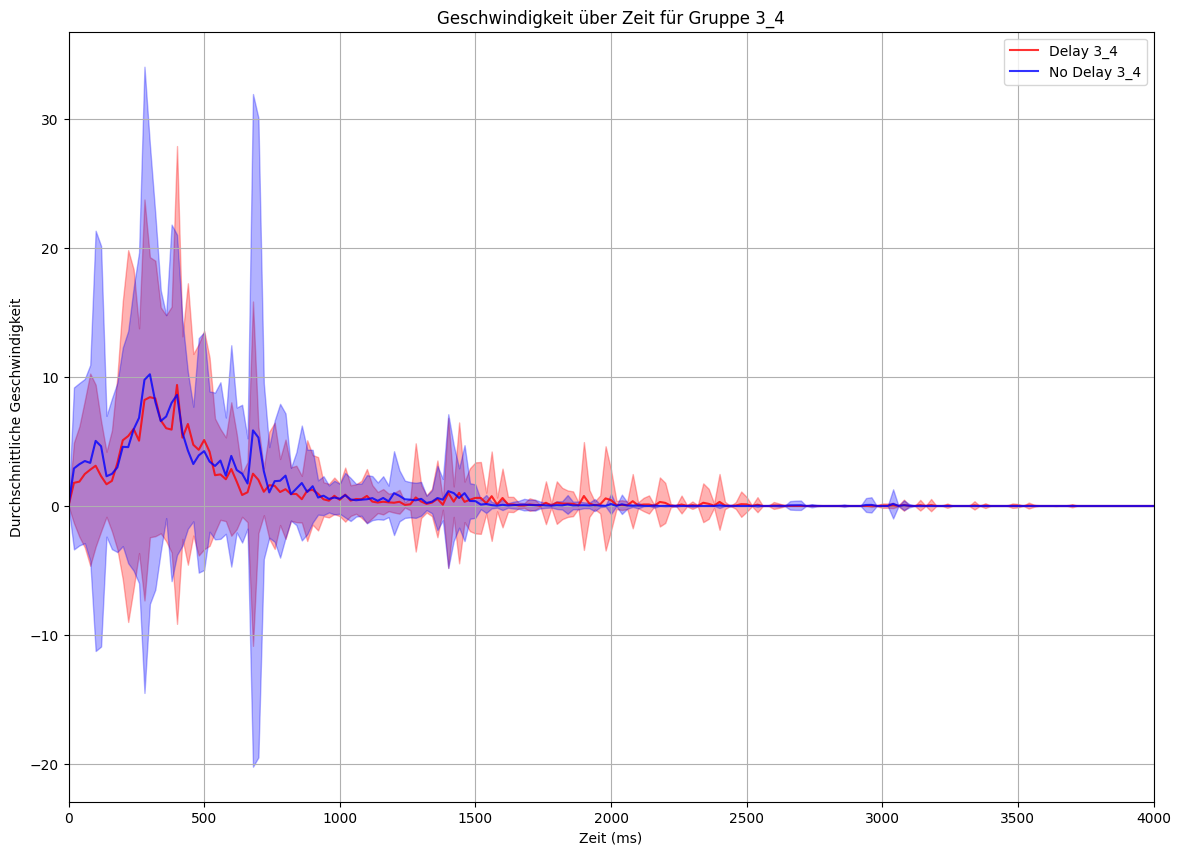

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Zeitachse: 0 bis 4000 ms in 20 ms Schritten
target_time_ms = np.arange(0, 4000 + 1, 20)  # 201 Punkte

# in 2d array für mittelwert
delay_speeds = np.vstack(avg_speed_all_groups["delay_3_4"])
no_delay_speeds = np.vstack(avg_speed_all_groups["no_delay_3_4"])

mean_delay = np.mean(delay_speeds, axis=0)
std_delay = np.std(delay_speeds, axis=0)

mean_no_delay = np.mean(no_delay_speeds, axis=0)
std_no_delay = np.std(no_delay_speeds, axis=0)

plt.figure(figsize=(14,10))

plt.plot(target_time_ms, mean_delay, label="Delay 3_4", color="red", alpha=0.8)
plt.plot(target_time_ms, mean_no_delay, label="No Delay 3_4", color="blue", alpha=0.8)

plt.fill_between(target_time_ms, mean_delay - std_delay, mean_delay + std_delay, color="red", alpha=0.3)
plt.fill_between(target_time_ms, mean_no_delay - std_no_delay, mean_no_delay + std_no_delay, color="blue", alpha=0.3)

plt.xlabel("Zeit (ms)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Geschwindigkeit über Zeit für Gruppe 3_4")
plt.xlim(0, 4000)
plt.legend()
plt.grid(True)
plt.show()


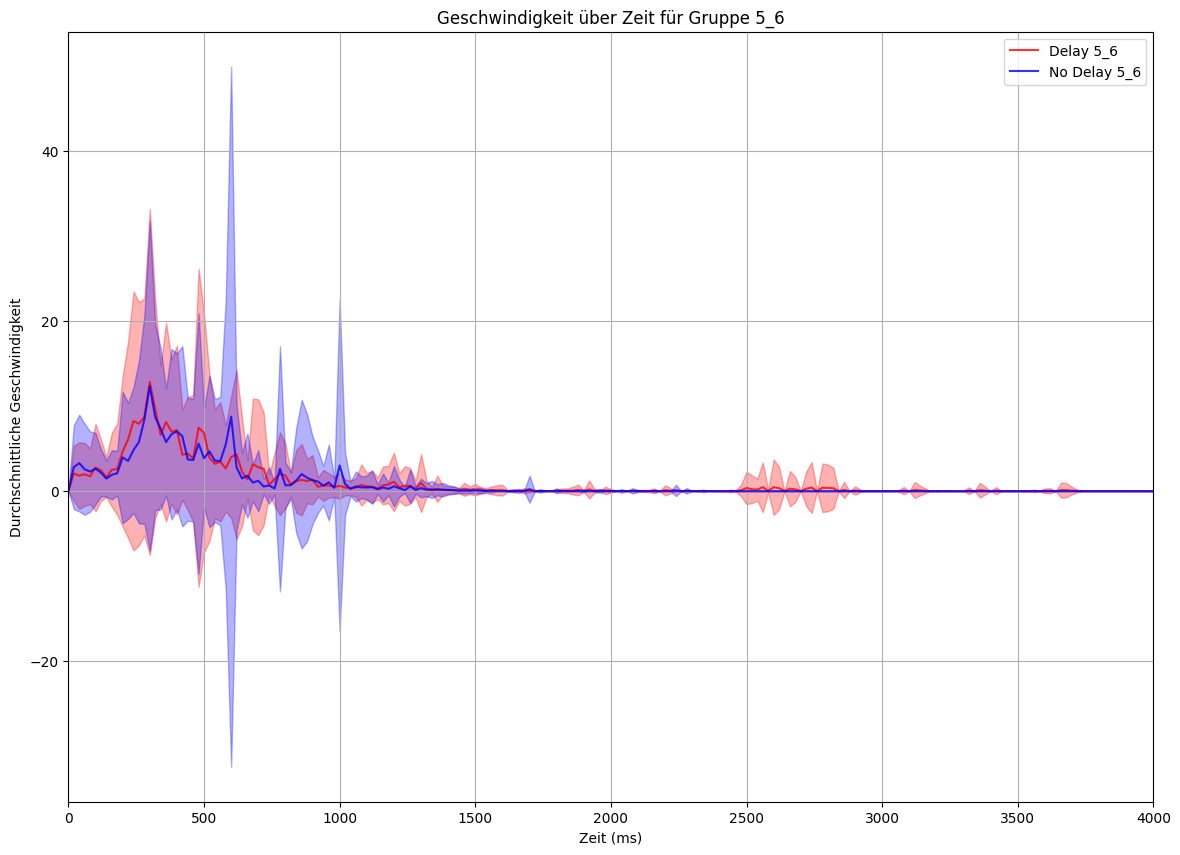

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Zeitachse: 0 bis 4000 ms in 20 ms Schritten
target_time_ms = np.arange(0, 4000 + 1, 20)  # 201 Punkte

# in 2d array für mittelwert
delay_speeds = np.vstack(avg_speed_all_groups["delay_5_6"])
no_delay_speeds = np.vstack(avg_speed_all_groups["no_delay_5_6"])

mean_delay = np.mean(delay_speeds, axis=0)
std_delay = np.std(delay_speeds, axis=0)

mean_no_delay = np.mean(no_delay_speeds, axis=0)
std_no_delay = np.std(no_delay_speeds, axis=0)

plt.figure(figsize=(14,10))

plt.plot(target_time_ms, mean_delay, label="Delay 5_6", color="red", alpha=0.8)
plt.plot(target_time_ms, mean_no_delay, label="No Delay 5_6", color="blue", alpha=0.8)

plt.fill_between(target_time_ms, mean_delay - std_delay, mean_delay + std_delay, color="red", alpha=0.3)
plt.fill_between(target_time_ms, mean_no_delay - std_no_delay, mean_no_delay + std_no_delay, color="blue", alpha=0.3)

plt.xlabel("Zeit (ms)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Geschwindigkeit über Zeit für Gruppe 5_6")
plt.xlim(0, 4000)
plt.legend()
plt.grid(True)
plt.show()


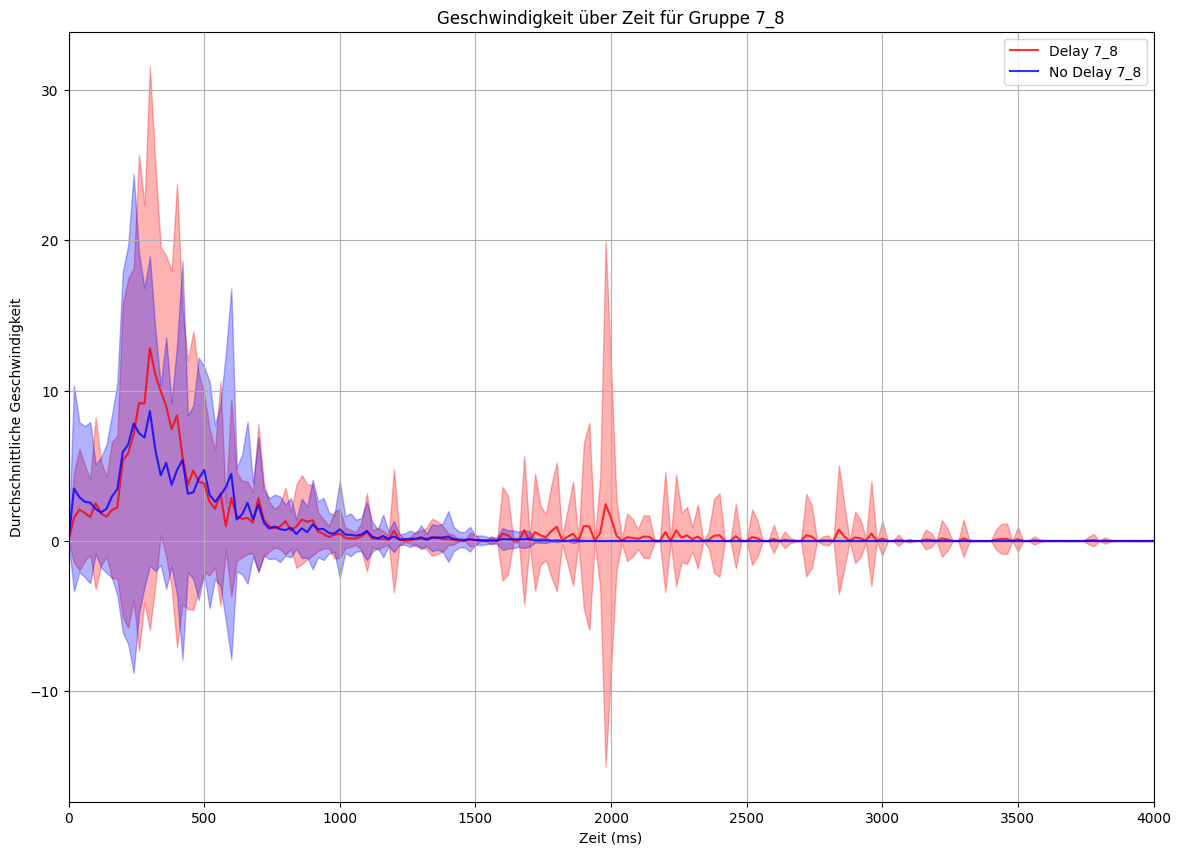

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Zeitachse: 0 bis 4000 ms in 20 ms Schritten
target_time_ms = np.arange(0, 4000 + 1, 20)  # 201 Punkte

# in 2d array für mittelwert
delay_speeds = np.vstack(avg_speed_all_groups["delay_7_8"])
no_delay_speeds = np.vstack(avg_speed_all_groups["no_delay_7_8"])

mean_delay = np.mean(delay_speeds, axis=0)
std_delay = np.std(delay_speeds, axis=0)

mean_no_delay = np.mean(no_delay_speeds, axis=0)
std_no_delay = np.std(no_delay_speeds, axis=0)

plt.figure(figsize=(14,10))

plt.plot(target_time_ms, mean_delay, label="Delay 7_8", color="red", alpha=0.8)
plt.plot(target_time_ms, mean_no_delay, label="No Delay 7_8", color="blue", alpha=0.8)

plt.fill_between(target_time_ms, mean_delay - std_delay, mean_delay + std_delay, color="red", alpha=0.3)
plt.fill_between(target_time_ms, mean_no_delay - std_no_delay, mean_no_delay + std_no_delay, color="blue", alpha=0.3)

plt.xlabel("Zeit (ms)")
plt.ylabel("Durchschnittliche Geschwindigkeit")
plt.title("Geschwindigkeit über Zeit für Gruppe 7_8")
plt.xlim(0, 4000)
plt.legend()
plt.grid(True)
plt.show()


### Neuen Dataframe erstellen, mit delay, start_latency und durchschnittliche geschwindigkeit

In [100]:
df_delay_1_2_new = pd.concat(delay_1_2, ignore_index=True)
df_delay_3_4_new = pd.concat(delay_3_4, ignore_index=True)
df_delay_5_6_new = pd.concat(delay_5_6, ignore_index=True)
df_delay_7_8_new = pd.concat(delay_7_8, ignore_index=True)

df_no_delay_1_2_new = pd.concat(no_delay_1_2, ignore_index=True)
df_no_delay_3_4_new = pd.concat(no_delay_3_4, ignore_index=True)
df_no_delay_5_6_new = pd.concat(no_delay_5_6, ignore_index=True)
df_no_delay_7_8_new = pd.concat(no_delay_7_8, ignore_index=True)


In [101]:
df_delay_3_4_new.iloc[60:120]

,round,trial,timestamp,mouse_x,mouse_y,version,id,euk_dist,speed,targetPos
60,3,1,"[11:07:36.870, 11:07:36.922, 11:07:36.936, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0.0, 0.0, 0, 0.0, 0, 0.0, 0.0, 0.0, 0...",l
61,3,3,"[11:07:47.189, 11:07:47.238, 11:07:47.273, 11:...","[0.0, -0.017999999999999988, -0.02499999999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.017999999999999988, 0.0070000000000000...","[0.0, 0, 0.8999999999999994, 0, 1.000000000000...",l
62,3,4,"[11:07:52.872, 11:07:52.889, 11:07:52.937, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0, ...",l
63,3,5,"[11:07:57.938, 11:07:57.955, 11:07:57.974, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0, 0.0, 0.0, 0, ...",l
64,3,6,"[11:08:02.339, 11:08:02.356, 11:08:02.373, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0, 0, 0.0...",l
65,3,7,"[11:08:07.456, 11:08:07.490, 11:08:07.505, 11:...","[0.0, 0.0, 0.0, 0.01100000000000001, 0.06, 0.1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.01100000000000001, 0.0489999...","[0.0, 0.0, 0.0, 0, 0.5500000000000005, 2.44999...",l
66,3,11,"[11:08:26.924, 11:08:26.973, 11:08:27.026, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0.0, 0, 0, 0.0, 0.0, 0, 0, 0.0, 0, 0....",l
67,3,12,"[11:08:32.306, 11:08:32.357, 11:08:32.373, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0.0, 0.0, 0.0, 0, 0.0, 0, 0, 0.0, 0.0...",l
68,3,13,"[11:08:37.374, 11:08:37.391, 11:08:37.440, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0, 0, 0.0, 0, 0.0, 0.0, 0.0, 0, 0, 0.0, ...",l
69,3,15,"[11:08:48.224, 11:08:48.257, 11:08:48.309, 11:...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",lld,1268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0, 0, 0.0, 0.0, 0, 0, 0.0, 0, 0.0, ...",l


In [104]:
def extract_metrics(df, time_step_ms=20):
    delays = []
    start_latencies = []
    avg_speeds = []

    for speed_list in df['speed']:
        # erster index bei dem speed > 0 (oder größer als threshold?)
        delay_indices = [i for i, v in enumerate(speed_list) if v > 0]
        if delay_indices:
            delay = delay_indices[0]
        else:
            delay = None

        delays.append(delay)
        start_latencies.append(delay * time_step_ms if delay is not None else None)
        avg_speeds.append(np.mean(speed_list))

    df['delay'] = delays
    df['start_latency_ms'] = start_latencies
    df['avg_speed'] = avg_speeds

    return df

In [ ]:
df_delay_1_2_new = extract_metrics(df_delay_1_2_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]
df_delay_3_4_new = extract_metrics(df_delay_3_4_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]
df_delay_5_6_new = extract_metrics(df_delay_5_6_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]
df_delay_7_8_new = extract_metrics(df_delay_7_8_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]

df_no_delay_1_2_new = extract_metrics(df_no_delay_1_2_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]
df_no_delay_3_4_new = extract_metrics(df_no_delay_3_4_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]
df_no_delay_5_6_new = extract_metrics(df_no_delay_5_6_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]
df_no_delay_7_8_new = extract_metrics(df_no_delay_7_8_new)[['trial', 'delay', 'start_latency_ms', 'avg_speed', 'id']]

### überall hinzufügen ob delay oder nicht. 1 wenn delay

In [ ]:
df_delay_1_2_new['has_delay'] = 1
df_delay_3_4_new['has_delay'] = 1
df_delay_5_6_new['has_delay'] = 1
df_delay_7_8_new['has_delay'] = 1

df_no_delay_1_2_new['has_delay'] = 0
df_no_delay_3_4_new['has_delay'] = 0
df_no_delay_5_6_new['has_delay'] = 0
df_no_delay_7_8_new['has_delay'] = 0

C:\Users\m_uel\AppData\Local\Temp\ipykernel_14912\1096037185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delay_1_2_new['has_delay'] = 1


In [112]:
all_trials = pd.concat([
    df_delay_1_2_new, df_delay_3_4_new, df_delay_5_6_new, df_delay_7_8_new,
    df_no_delay_1_2_new, df_no_delay_3_4_new, df_no_delay_5_6_new, df_no_delay_7_8_new
], ignore_index=True)

In [113]:
len(all_trials)

24949

In [111]:
df_delay_1_2_new

,trial,delay,start_latency_ms,avg_speed,id,has_delay
0,1,15.0,300.0,2.282611,1085,1
1,3,1.0,20.0,2.369075,1085,1
2,4,0.0,0.0,6.839358,1085,1
3,7,0.0,0.0,2.772394,1085,1
4,10,0.0,0.0,3.049162,1085,1
...,...,...,...,...,...,...
3103,55,10.0,200.0,2.533801,9817,1
3104,56,15.0,300.0,1.868965,9817,1
3105,57,9.0,180.0,2.530988,9817,1
3106,58,6.0,120.0,1.902270,9817,1


In [108]:
df_delay_1_2_new

,trial,delay,start_latency_ms,avg_speed,id
0,1,15.0,300.0,2.282611,1085
1,3,1.0,20.0,2.369075,1085
2,4,0.0,0.0,6.839358,1085
3,7,0.0,0.0,2.772394,1085
4,10,0.0,0.0,3.049162,1085
...,...,...,...,...,...
3103,55,10.0,200.0,2.533801,9817
3104,56,15.0,300.0,1.868965,9817
3105,57,9.0,180.0,2.530988,9817
3106,58,6.0,120.0,1.902270,9817


In [109]:
output_dir = "output_data"
os.makedirs(output_dir, exist_ok=True)

df_delay_1_2_new.to_csv(os.path.join(output_dir, "delay_1_2.csv"), index=False)
df_delay_3_4_new.to_csv(os.path.join(output_dir, "delay_3_4.csv"), index=False)
df_delay_5_6_new.to_csv(os.path.join(output_dir, "delay_5_6.csv"), index=False)
df_delay_7_8_new.to_csv(os.path.join(output_dir, "delay_7_8.csv"), index=False)

df_no_delay_1_2_new.to_csv(os.path.join(output_dir, "no_delay_1_2.csv"), index=False)
df_no_delay_3_4_new.to_csv(os.path.join(output_dir, "no_delay_3_4.csv"), index=False)
df_no_delay_5_6_new.to_csv(os.path.join(output_dir, "no_delay_5_6.csv"), index=False)
df_no_delay_7_8_new.to_csv(os.path.join(output_dir, "no_delay_7_8.csv"), index=False)


In [114]:
output_dir = "all_trials_new_df"
os.makedirs(output_dir, exist_ok=True)
all_trials.to_csv(os.path.join(output_dir, "all_trials.csv"), index=False)